To build intuition about convolutions lets implement an edge  filter 

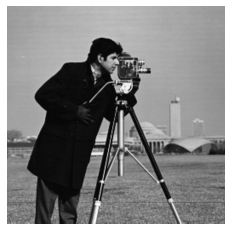

In [ ]:
from skimage import data
import matplotlib.pyplot as plt

camera = data.camera()
plt.figure(figsize=(4, 4))
plt.imshow(camera, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
import numpy as np

kernel = np.array([[-1,-1,-1],
                   [-1,8,-1],
                   [-1,-1,-1]])
kernel = kernel/8.0

(1) Write a for loop to convolve this kernel with the image. Apply the filter with stride=2 (no overlap). Plot the absolute value of the output using matplotlib's imshow to visualize the edge detection.

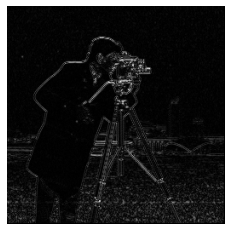

In [ ]:
H=512
W=512
stride=2
ker_sz=3

output = np.zeros((256,256))
for h in np.arange(1, H-2, stride):
  for w in np.arange(1, W-2, stride):
    val = (camera[h-(ker_sz-stride):h+(ker_sz-stride)+1,w-(ker_sz-stride):w+(ker_sz-stride)+1]*kernel).sum()
    output[int(h/stride),int(w/stride)] = val


plt.figure(figsize=(4, 4))
plt.imshow(np.abs(output), cmap='gray')
plt.axis('off')
plt.show()

Now let's look at conv2d in torch



In [ ]:
import torch

conv_nn = torch.nn.Conv2d(1, 5, kernel_size=3,stride=2)
conv_nn.bias.data.zero_()
img_in = torch.FloatTensor(camera)[None,None,:,:]

filtered_camera = conv_nn(img_in)
print(filtered_camera.shape)
print(conv_nn.weight.data.shape)

#To compute the output keep in mind these variables and the formula for H,W output in torch.nn.Conv2d
print(conv_nn.dilation)
print(conv_nn.stride)
print(conv_nn.padding)
print(conv_nn.kernel_size)


torch.Size([1, 5, 255, 255])
torch.Size([5, 1, 3, 3])
(1, 1)
(2, 2)
(0, 0)
(3, 3)


(2) Consider a minibatch of a randomly trained image, pass it through the randomly initialized convolutional layer above. Take the weights from the conv layer above and implement the convolution using a for loop confirm your custom function has the same behavior as conv_nn(camera) on the camera image

---



In [ ]:
mini_batch = 10
height=width = 12
input_features = 1
num_features = 5
toy_train_images = torch.rand(mini_batch, input_features, height, width) #this is usually the structure we input image data

import torch.nn as nn
import copy

my_weight=copy.deepcopy(conv_nn.weight.data)



def my_conv_nn(x):
    #Implement a for loop based convolution here. Don't worry about making sure autograd tracks this.
    H = height
    W = width
    ker_sz = 3
    stride = 2

    weight = my_weight
    weight = weight.view(1 , num_features, 1, ker_sz*ker_sz)

    output = torch.zeros((mini_batch,num_features,int((height-2)/stride),int((width-2)/stride)))
    for h in np.arange(1, H-2, stride):
      for w in np.arange(1, W-2, stride):
        a = x[:,:,h-(ker_sz-stride):h+(ker_sz-stride)+1,w-(ker_sz-stride):w+(ker_sz-stride)+1]
        a = a.contiguous()
        b = weight
        a = a.view(mini_batch, input_features, ker_sz*ker_sz, 1 )
        val = torch.matmul(b,a).squeeze()
        output[:,:,int(h/stride),int(w/stride)] = val
    return output

assert(torch.norm(my_conv_nn(toy_train_images)-conv_nn(toy_train_images))<1e-3)

Visualizing filters. Download the trained alexnet model as follows

In [ ]:
import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()
print(model)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


(3) The alexnet model has a the first layer filters of size 11. Let's visualize a randomly selected subset of 10 of these filters as well as their output for the astronaut image. Apply them individually to the astronaut image.

In [ ]:
# No need to modify this cell it preprocesses the astronaut data for alexnet
import numpy as np
from skimage import data
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
print(data.astronaut().shape)
astronaut_processed = data.astronaut()/255.0
astronaut_processed = (astronaut_processed-mean[None,None,:])/std[None,None,:]


(512, 512, 3)


Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
torch.Size([1, 64, 127, 127])
torch.Size([127, 127])


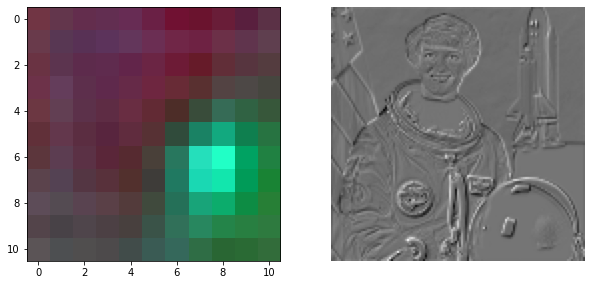

torch.Size([127, 127])


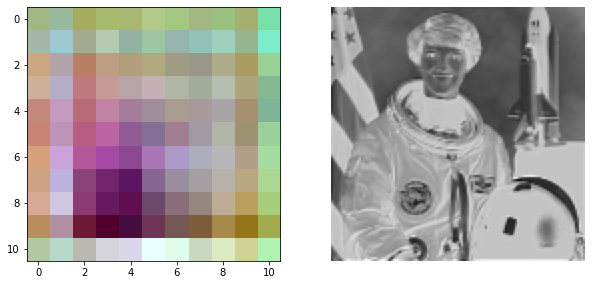

torch.Size([127, 127])


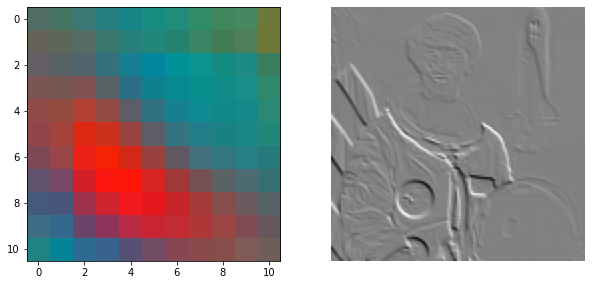

torch.Size([127, 127])


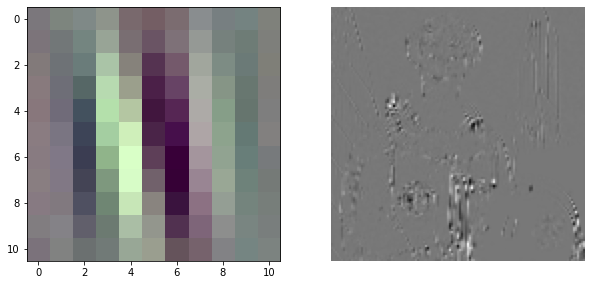

torch.Size([127, 127])


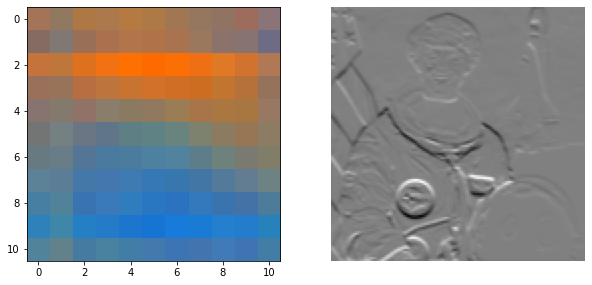

torch.Size([127, 127])


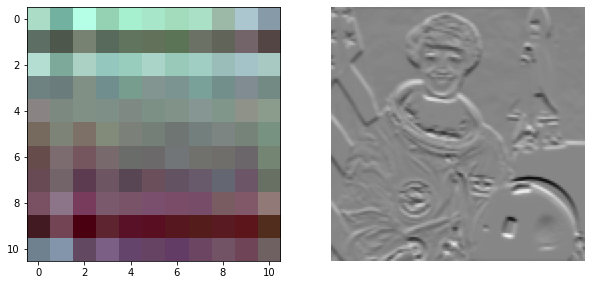

torch.Size([127, 127])


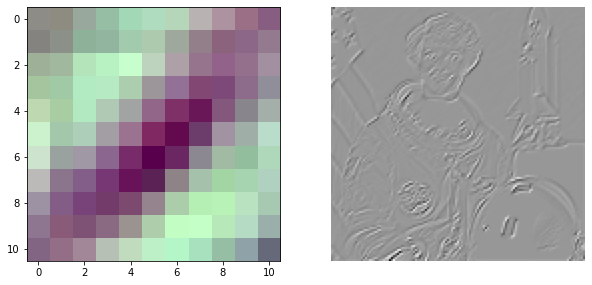

torch.Size([127, 127])


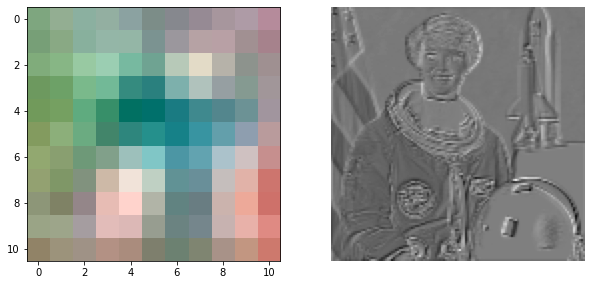

torch.Size([127, 127])


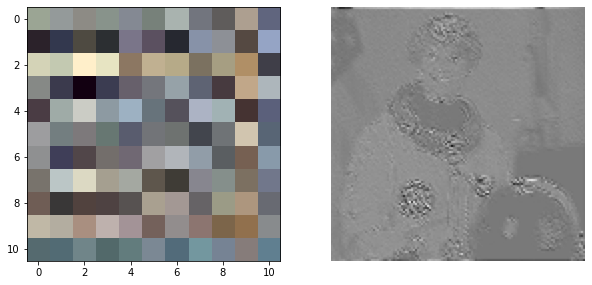

torch.Size([127, 127])


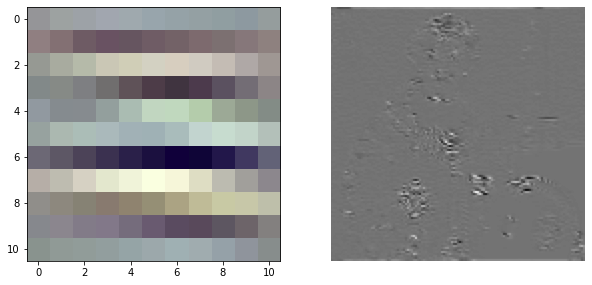

In [ ]:
import matplotlib.pyplot as plt

first_layer = model.features[0]
first_layer_weights = first_layer.weight

image = torch.FloatTensor(astronaut_processed).permute(2,1,0).unsqueeze(0)

#Write your answer here
print(first_layer)
image_features = first_layer(image)
print(image_features.shape)
ind = np.arange(0,10)

#print(filter.data.cpu().numpy().shape)
for i in ind:
  filter = first_layer_weights[i]
  filter = filter.permute(2,1,0).data.cpu().numpy()
  imag_out = image_features[0][i].T
  print(imag_out.shape)
  plt.figure(figsize=(10, 10))
  plt.subplot(1,2,1)
 
  plt.imshow((filter - filter.min()) / filter.ptp(),cmap='gray')
  plt.subplot(1,2,2)
  plt.imshow(imag_out.data.cpu().numpy(),cmap='gray')
  plt.axis('off')
  plt.show()

Build a small convnet using nn.modules with two layers and forward pass the astronaut image through it. You do not need to train it for this excercise. 

The convnet should have the following specifications. It should use relu non-linearities and initializations will be the default. Use the nn.Conv2d modules for this 

layer 1 - 5x5 filters with 16 feature maps stride 2 with 10 feature maps

layer 2 - 2x2 pooling 

layer 3 - 3x3 filters with 32 feautre maps

layer 4 - final linear projection

In your forward function add some print statemetns to show the sizes of the image at each layer. 


In [ ]:
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels= 3 , out_channels=16, kernel_size= 5, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(in_channels= 16 , out_channels=32, kernel_size= 3, stride=2)
        self.linear = torch.nn.Linear(63*63*32,5)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        print(x.shape)

        x = self.pool(x)
        print(x.shape) 

        x = F.relu(self.conv2(x))
        print(x.shape)
        x = self.linear(x.view(-1,63*63*32))
        print(x.shape)

        return x

model = MyModel()
in_image = torch.FloatTensor(astronaut_processed).permute(2,0,1)
in_image = in_image.unsqueeze(0) #BxFxHxW
model(in_image)

torch.Size([1, 16, 254, 254])
torch.Size([1, 16, 127, 127])
torch.Size([1, 32, 63, 63])
torch.Size([1, 5])


tensor([[ 0.1692, -0.0645,  0.0615,  0.1002, -0.1068]],
       grad_fn=<AddmmBackward>)